In [75]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,f1_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,BayesianRidge
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pymc3 as pm
from scipy.stats import boxcox
from theano import tensor as T


In [76]:
import io
df=pd.read_csv('/kaggle/input/walmart-dataset/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


<AxesSubplot: >

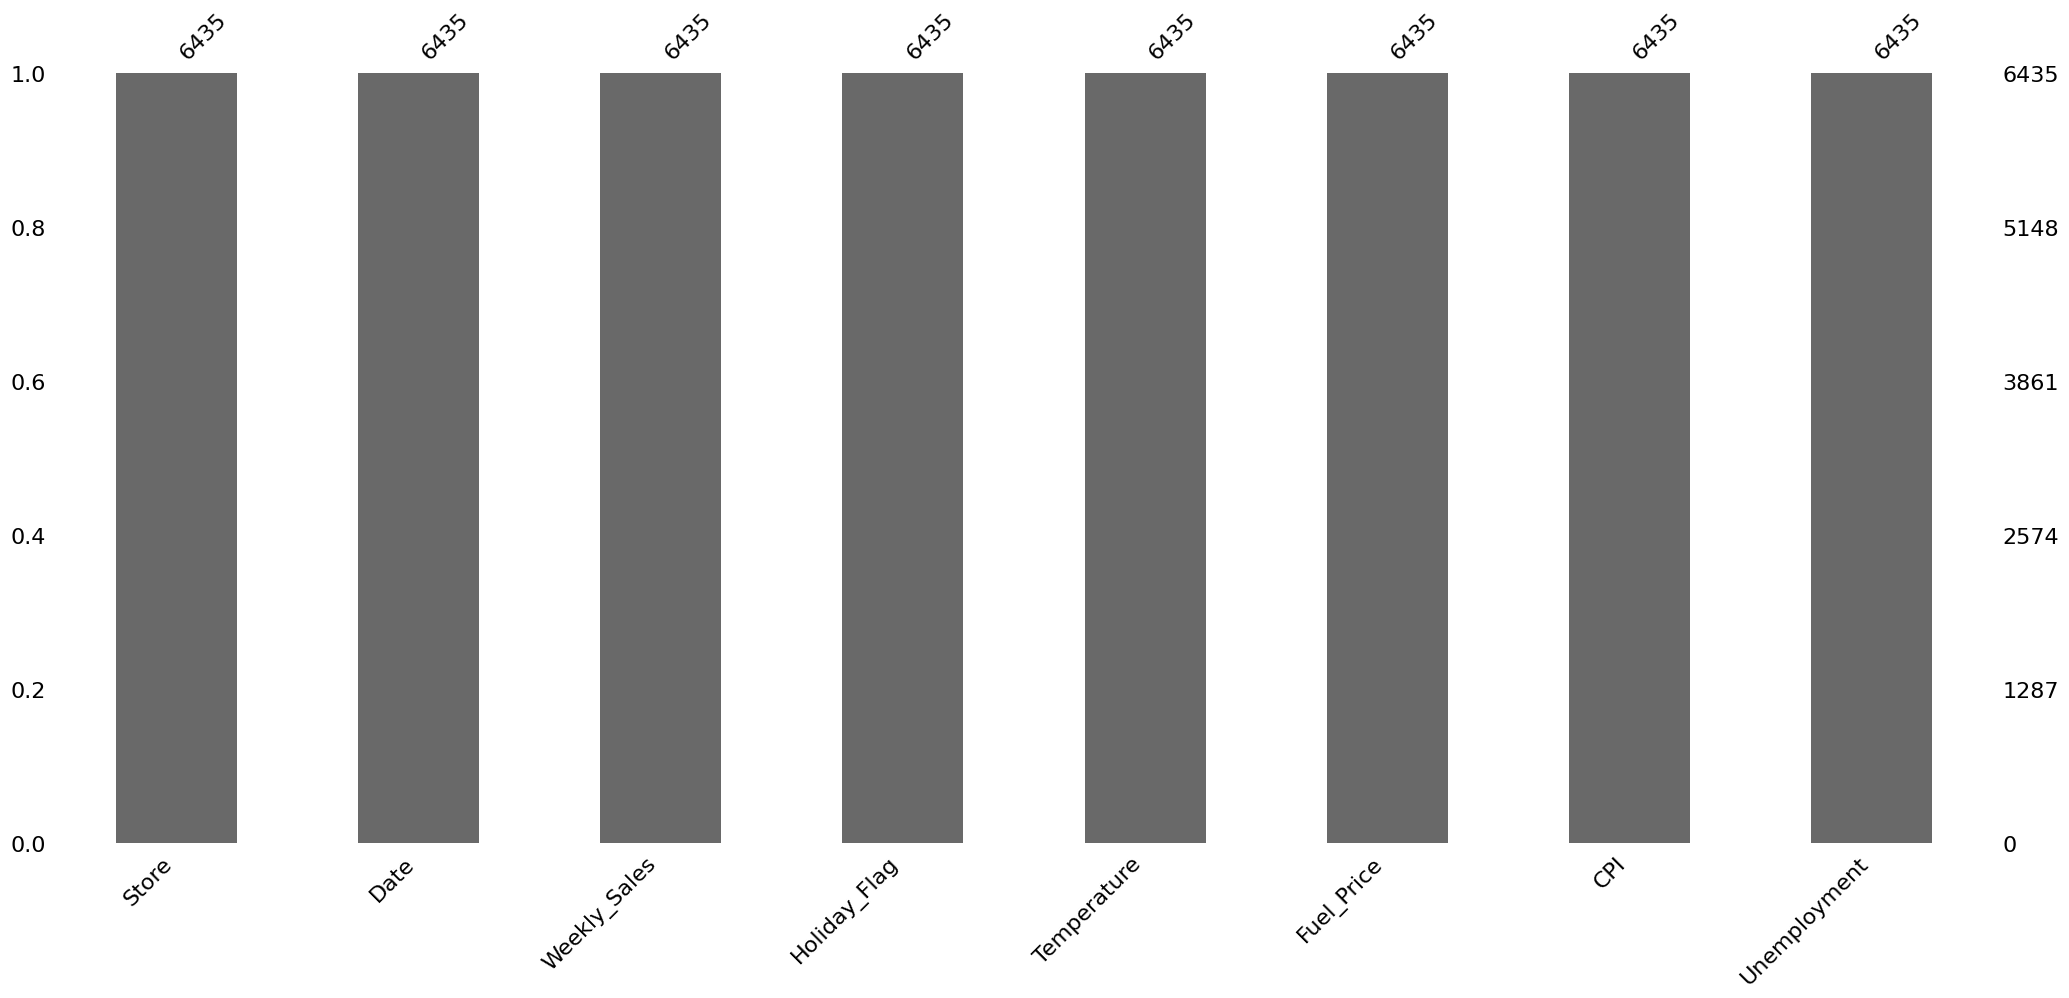

In [14]:
# NAN VISUALIZATION
msno.bar(df)
## THUS THERE ARE NO NAN VALUES BY THE GRAPH VISUALIZATION

In [77]:
# THERE ARE 2 CATEGORICAL COLUMNS AND 6 NON CATEGORICAL COLUMNS
# STORE AND HOLIDAYS

df['Date']=pd.to_datetime(df['Date'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.describe()
## Temperature values looks litte bit fishy

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
##Temperature and unemployement have some outliers
## there are outliers in weekly sales too, but it is explained by holiday peak sales

In [78]:
# REPLACING OUTLIERS OF TEMPERATURE WITH AVERAGE (BEFORE AND AFTER VALUE)
Q1,Q3= df['Temperature'].quantile(0.25),df['Temperature'].quantile(0.75),
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
for i in df['Temperature']:
    if i>upper_bound or i<lower_bound:
        id1=df[df['Temperature']==i][:1].index-1
        id2=df[df['Temperature']==i][:1].index+1
        before_value=df.iloc[id1]['Temperature'].values[0]
        after_value=df.iloc[id2]['Temperature'].values[0]
        df['Temperature'].replace(i,(before_value+after_value)/2,inplace=True)


In [79]:
# REPLACINNG OUTLIERS OF EMPLOYEMENT WITH MEAN
Q1,Q3= df['Unemployment'].quantile(0.25),df['Unemployment'].quantile(0.75),
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
for i in df['Unemployment']:
    if i>upper_bound or i<lower_bound:
        df['Unemployment'].replace(i,df['Unemployment'].mean(),inplace=True)

skewness of unemployement -0.12416247265866173

mean is 7.728662872620826 and standard deviation is 1.1958054336587187


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unemployement distribution (Original)')

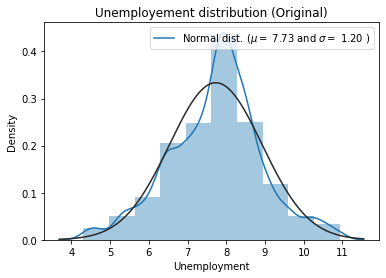

In [ ]:
sns.distplot(df['Unemployment'],fit=norm,bins=10);
print('skewness of unemployement',skew(df['Unemployment']))
(mean,standard_deviation) = norm.fit(df['Unemployment'])
print('mean is',mean,'and standard deviation is',standard_deviation)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, standard_deviation)],
            loc = 'best')
plt.title('Unemployement distribution (Original)')
## UNEMPLOYEMENT IS CLOSE TO NORMAL DISTRIBUTION
## SO WE CAN USE MEAN AS OUTLIER REPLACEMENT

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


skewness of Weekly_Sales 0.6682059921068103

mean is 1046964.8775617715 and standard deviation is 564322.7690195543


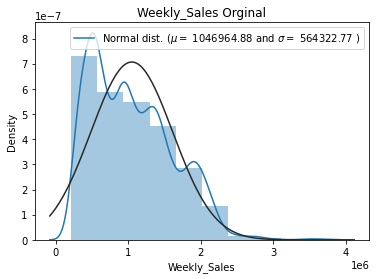

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


skewness of Temperature -0.331824636250604

mean is 60.66863403263403 and standard deviation is 18.429745952904533


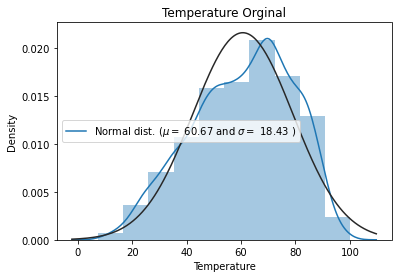

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


skewness of Fuel_Price -0.09613588414498364

mean is 3.358606837606838 and standard deviation is 0.4589840399402098


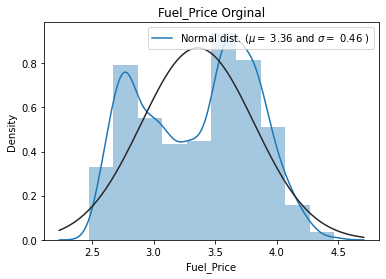

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


skewness of CPI 0.06347704896208373

mean is 171.57839384878014 and standard deviation is 39.35365415724738


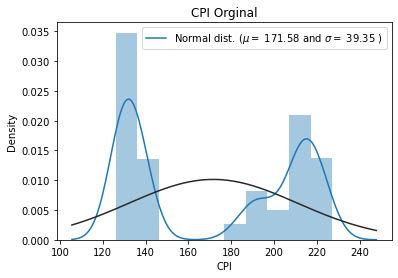

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)


skewness of Unemployment -0.12416247265866173

mean is 7.728662872620826 and standard deviation is 1.1958054336587187


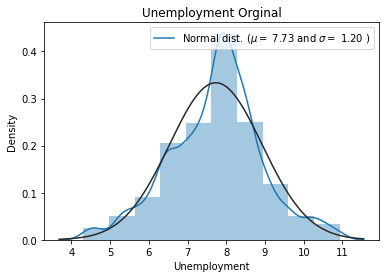

In [ ]:
## CHECKING SKEWNESS
cols=['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']
for i in cols:
    sns.distplot(df[i],bins=10,fit=norm);
    print(f'skewness of {i}',skew(df[i]))
    (mean,standard_deviation) = norm.fit(df[i])
    print('mean is',mean,'and standard deviation is',standard_deviation)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, standard_deviation)],
                loc = 'best')
    plt.title(f'{i} Orginal')
    plt.show()

Text(0.5, 1.0, 'Unemployment')

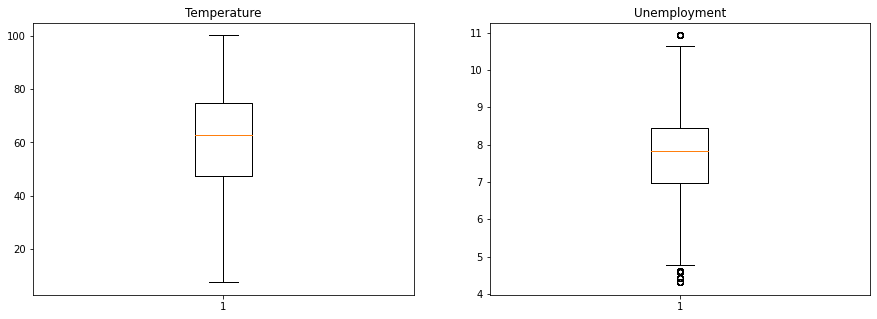

In [ ]:
# REMOVED MOST OF THE OUTLIERS FROM TEMPERATURE AND UNEMPLOYMENT 
fig, (ax1, ax2)  = plt.subplots(1, 2,figsize=(15,5))
ax1.boxplot(df['Temperature'])
ax1.set_title('Temperature')
ax2.boxplot(df['Unemployment'])
ax2.set_title('Unemployment')
#NO OUTLIERS

In [ ]:
## EXPLORATION
#figure(figsize=(15,5), dpi=80)
Total_holiday_sales=df[df['Holiday_Flag']==1]['Weekly_Sales'].mean()
Total_non_holiday_sales=df[df['Holiday_Flag']==0]['Weekly_Sales'].mean()

In [ ]:
data = {'Avg Weekly Holiday sales':Total_holiday_sales, 'Avg_non_weekly_holiday_sales':Total_non_holiday_sales}

Text(0.5, 1.0, 'Holiday vs Non Holiday (Average)')

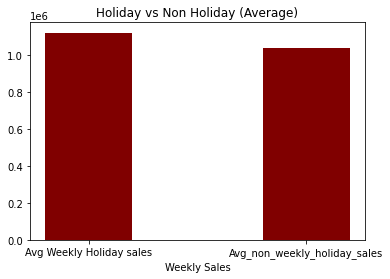

In [ ]:
plt.bar(list(data.keys()), list(data.values()), color ='maroon',
        width = 0.4)
plt.xlabel('Weekly Sales')
plt.title('Holiday vs Non Holiday (Average)')
# The holiday weeks has more sales compared to non-weekly

Text(0.5, 1.0, 'Store number vs weekly sales')

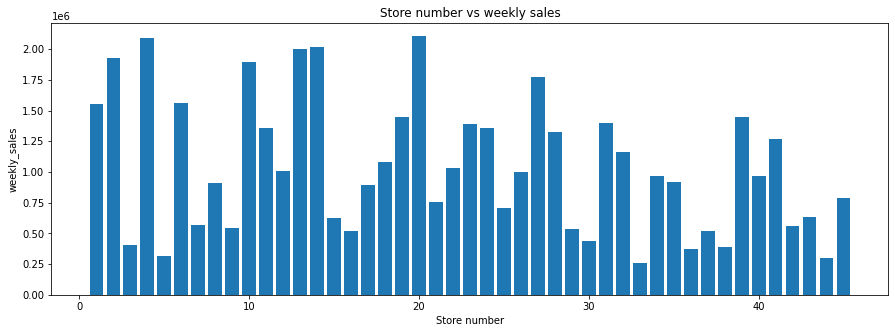

In [ ]:
store_sales=[]
store_no=[]
for i in df['Store'].unique():
    store_sales.append(df[df['Store']==i]['Weekly_Sales'].mean())
    store_no.append(i)
fig, ax1 = plt.subplots(1,1, figsize=(15,5))

plt.bar(store_no,store_sales)
plt.xlabel('Store number')
plt.ylabel('weekly_sales')
plt.title('Store number vs weekly sales')

Text(0.5, 1.0, 'Store-Wise sales')

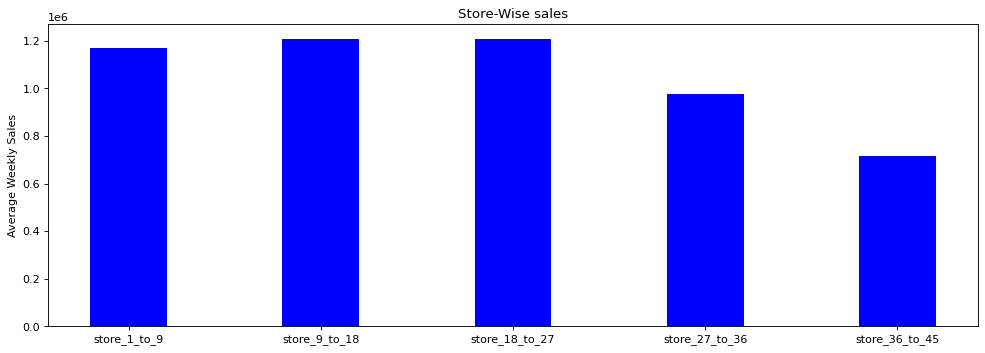

In [ ]:
store_1_to_9=[]
for i in range(1,9):
    mean_value_1to9=0
    mean_value_1to9=df[df['Store']==i]['Weekly_Sales'].mean()
    store_1_to_9.append(mean_value_1to9)
store_9_to_18=[]
for i in range(9,18):
    mean_value_9to18=0
    mean_value_9to18=df[df['Store']==i]['Weekly_Sales'].mean()
    store_9_to_18.append(mean_value_9to18)
store_18_to_27=[]
for i in range(18,27):
    mean_value_18to27=0
    mean_value_18to27=df[df['Store']==i]['Weekly_Sales'].mean()
    store_18_to_27.append(mean_value_18to27)
store_27_to_36=[]
for i in range(27,36):
    mean_value_27to36=0
    mean_value_27to36=df[df['Store']==i]['Weekly_Sales'].mean()
    store_27_to_36.append(mean_value_27to36)
store_36_to_45=[]
for i in range(36,45):
    mean_value_36to45=0
    mean_value_36to45=df[df['Store']==i]['Weekly_Sales'].mean()
    store_36_to_45.append(mean_value_36to45)
store_vis={'store_1_to_9':np.mean(store_1_to_9),
           'store_9_to_18':np.mean(store_9_to_18),
           'store_18_to_27':np.mean(store_18_to_27),
           'store_27_to_36':np.mean(store_27_to_36),
           'store_36_to_45':np.mean(store_36_to_45)}
figure(figsize=(15,5), dpi=80)
plt.bar(list(store_vis.keys()), list(store_vis.values()), color ='blue',
        width = 0.4)
plt.ylabel('Average Weekly Sales')
plt.title('Store-Wise sales')
# The stores from 27 to 36 has less sales than rest of the sales
# Thus weekly sales is somewhat dependent on stores, as the store number is between 27 to 45, the sales are less

Text(0.5, 1.0, 'weekly_sales vs Temperature')

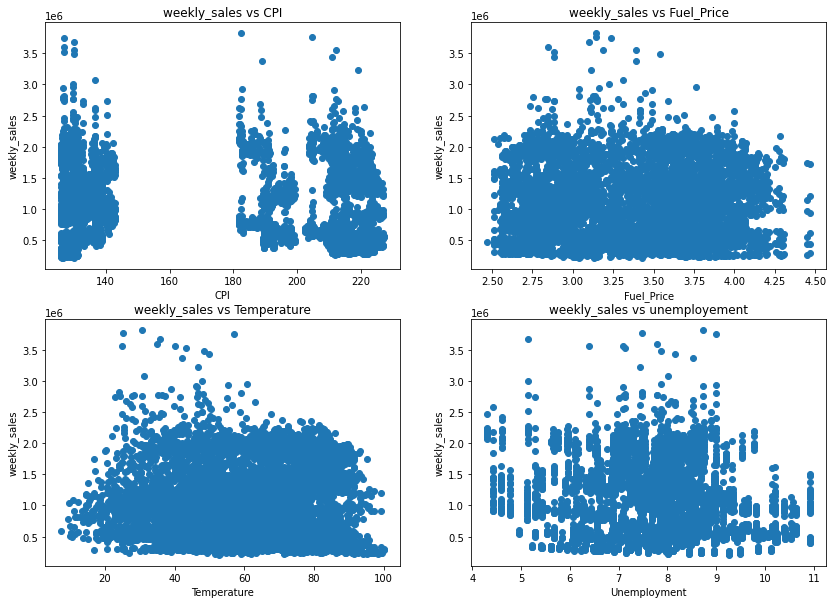

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs[1,1].scatter(df[df.columns[-1]],df['Weekly_Sales'])
axs[1,1].set_xlabel('Unemployment')
axs[1,1].set_ylabel('weekly_sales')
axs[1,1].set_title('weekly_sales vs unemployement')
axs[0,0].scatter(df[df.columns[-2]],df['Weekly_Sales'])
axs[0,0].set_xlabel('CPI')
axs[0,0].set_ylabel('weekly_sales')
axs[0,0].set_title('weekly_sales vs CPI')
axs[0,1].scatter(df[df.columns[-3]],df['Weekly_Sales'])
axs[0,1].set_xlabel('Fuel_Price')
axs[0,1].set_ylabel('weekly_sales')
axs[0,1].set_title('weekly_sales vs Fuel_Price')
axs[1,0].scatter(df[df.columns[-4]],df['Weekly_Sales'])
axs[1,0].set_xlabel('Temperature')
axs[1,0].set_ylabel('weekly_sales')
axs[1,0].set_title('weekly_sales vs Temperature')
# NO SIGNIFICANT CORRELATION BETWEEN OTHER VARIABLES AND TEMPERATURE

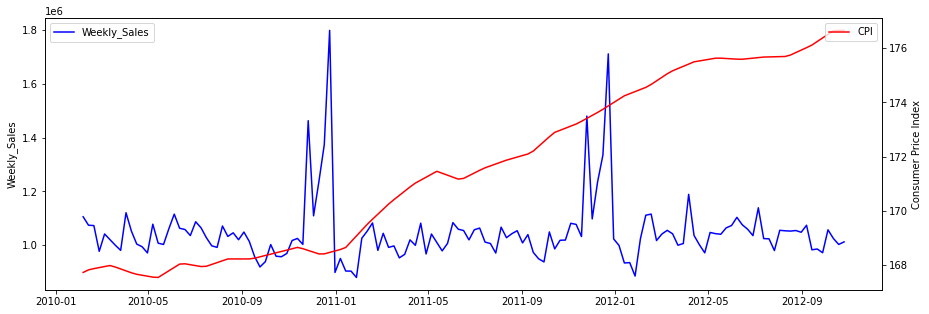

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['CPI'],color='red')
ax2.set_ylabel('Consumer Price Index')
ax2.legend(['CPI'],loc='upper right')
## THE CPI  HAS RISEN OVER THE TIME

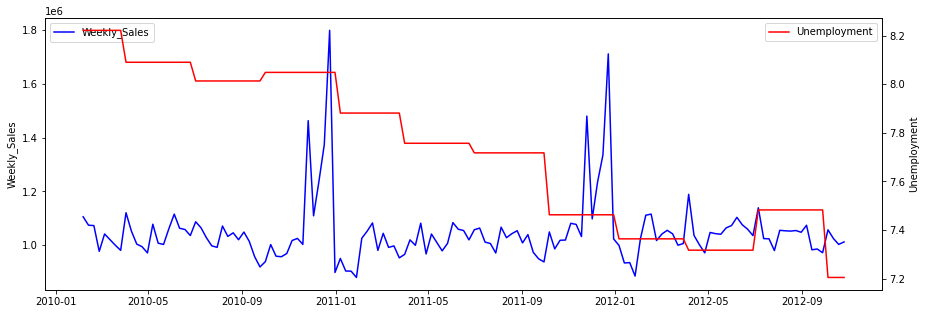

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Unemployment'],color='red')
ax2.set_ylabel('Unemployment')
ax2.legend(['Unemployment'],loc='upper right')
## THE Unemployement  HAS decreased OVER THE TIME 


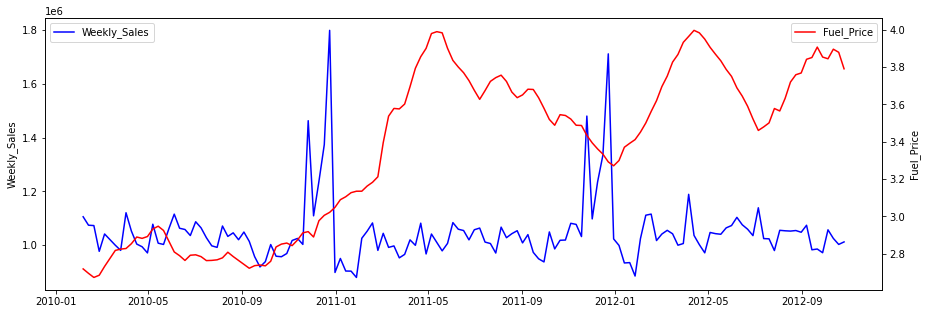

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Fuel_Price'],color='red')
ax2.set_ylabel('Fuel_Price')
ax2.legend(['Fuel_Price'],loc='upper right')

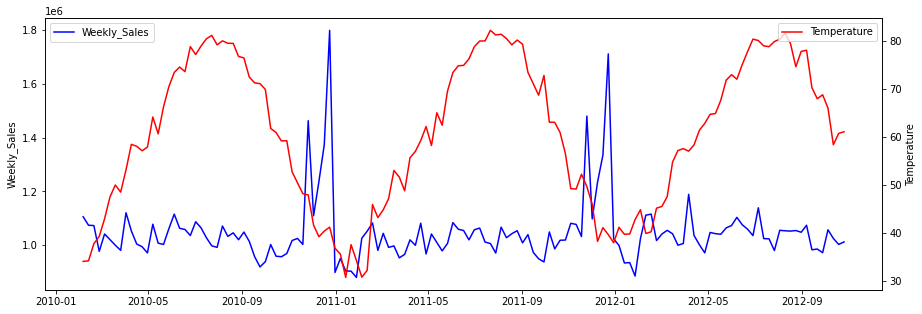

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Temperature'],color='red')
ax2.set_ylabel('Temperature')
ax2.legend(['Temperature'],loc='upper right')

In [18]:
Holidays={'SuperBowl':['2010-02','2011-02','2012-02'],
          'Labour Day':['2010-09','2011-09','2012-09'],
           'ThanksGiving':['2010-11','2011-11'],
           'Christmas':['2010-12','2011-12']}

<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

  ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')

<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

  ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')

<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `

Text(0.5, 0, 'Time')

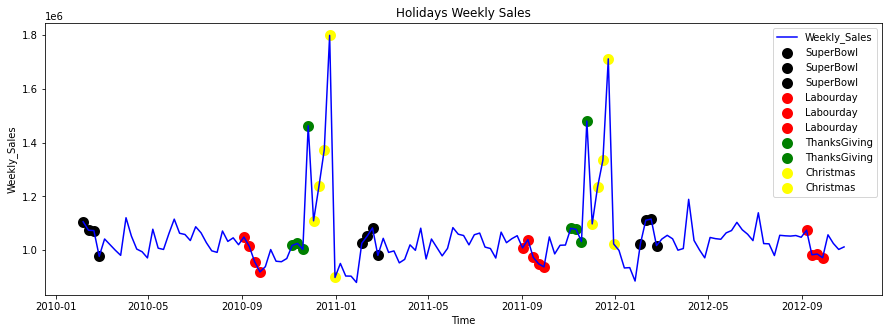

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue',label='Weekly_Sales')
ax1.set_ylabel('Weekly_Sales')
for i in Holidays['SuperBowl']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')
for i in Holidays['Labour Day']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Red',linewidths=5,label='Labourday')
for i in Holidays['ThanksGiving']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Green',linewidths=5,label='ThanksGiving')
for i in Holidays['Christmas']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Yellow',linewidths=5,label='Christmas')
ax1.legend()
ax1.set_title('Holidays Weekly Sales')
ax1.set_xlabel('Time')

In [ ]:
## THANKSGIVING AND CHRISTMAS ARE THE TWO MAJOR HOLIDAYS WHERE REVENUE SALES IS VERY MUCH HIGHER FOR WALMART
# THE NOVEMBER AND DECEMBER MONTH ARE THE MOST PROFITABLE MONTHS FOR WALMART
# upcoming months after major holiays which is january and february has lowest weekly sales for whole of walmart
# If a particualr week sees high sales because of holiay, the following week after it has lowest sales than the avg sales
# Christmas> tHANKSGIVING> LABOUR DAY> SUPER BOWL IS THE ORDER OF INCREASING WEEKLY SALES

In [81]:
df['Store'] = df.Store.astype('category')
df['Holiday_Flag'] = df.Holiday_Flag.astype('category')
target=df['Weekly_Sales']
#df1=df.drop('Weekly_Sales',axis=1)

In [82]:
def create_timefeature(df):
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['day'] = df['Date'].dt.day
    df1=df.drop('Date',axis=1)
    return df1

In [83]:
s=create_timefeature(df)
s.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,quarter,month,dayofyear,day
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,1,2,36,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,1,2,43,12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,1,2,50,19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,1,2,57,26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,1,3,64,5


In [84]:
for i in s.columns:
    a,b=scipy.stats.pearsonr(target,s[i])
    print(i,'-' ,a,' is correlation and ', b, ' is p-value')

Store - -0.33533201479281577  is correlation and  6.883078341514464e-169  is p-value
Weekly_Sales - 1.0  is correlation and  0.0  is p-value
Holiday_Flag - 0.036890968010414506  is correlation and  0.00307869926384778  is p-value
Temperature - -0.06396270832132275  is correlation and  2.817671641228444e-07  is p-value
Fuel_Price - 0.009463786314475135  is correlation and  0.44782874895250047  is p-value
CPI - -0.07263416204017623  is correlation and  5.438292612224682e-09  is p-value
Unemployment - -0.0736054166739826  is correlation and  3.3924324689728825e-09  is p-value
quarter - 0.06336274735182257  is correlation and  3.6379873623058575e-07  is p-value
month - 0.07614331979236579  is correlation and  9.607838869320523e-10  is p-value
dayofyear - 0.07424819039630853  is correlation and  2.4742174621518463e-09  is p-value
day - -0.017409461859021886  is correlation and  0.16259570379093236  is p-value


In [85]:
SuperBowl=['2010-02','2011-02','2012-02']
LabourDay=['2010-09','2011-09','2012-09']
ThanksGiving=['2010-11','2011-11']
Christmas=['2010-12','2011-12']
df['SuperBowl'] = 0
df['LabourDay'] = 0
df['ThanksGiving'] = 0
df['Christmas'] = 0
df.loc[df['Date'].dt.strftime('%Y-%m').isin(SuperBowl), 'SuperBowl'] = 1
df.loc[df['Date'].dt.strftime('%Y-%m').isin(LabourDay), 'LabourDay'] = 1
df.loc[df['Date'].dt.strftime('%Y-%m').isin(ThanksGiving), 'ThanksGiving'] = 1
df.loc[df['Date'].dt.strftime('%Y-%m').isin(Christmas), 'Christmas'] = 1


In [86]:
df_bay=df.copy()
s_bayesian=create_timefeature(df_bay)
s1_bayesian=pd.get_dummies(s_bayesian,drop_first=True)
s1_bayesian.head()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,quarter,month,dayofyear,day,SuperBowl,...,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Holiday_Flag_1
0,1643690.90,42.31,2.572,211.096358,8.106,1,2,36,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,38.51,2.548,211.242170,8.106,1,2,43,12,1,...,0,0,0,0,0,0,0,0,0,1
2,1611968.17,39.93,2.514,211.289143,8.106,1,2,50,19,1,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,46.63,2.561,211.319643,8.106,1,2,57,26,1,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,46.50,2.625,211.350143,8.106,1,3,64,5,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
scale = StandardScaler()
dt = s1_bayesian
columns=['Temperature','Fuel_Price','CPI','Unemployment','quarter','month','dayofyear','day','SuperBowl','LabourDay','ThanksGiving','Christmas']
X_train, X_test, y_train, y_test = train_test_split(
    dt[dt.columns[1:]],
    dt['Weekly_Sales'],
    test_size=0.2,
    random_state=42)
X_train.head(2)

,Temperature,Fuel_Price,CPI,Unemployment,quarter,month,dayofyear,day,SuperBowl,LabourDay,...,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Holiday_Flag_1
1033,75.32,2.582,214.878556,6.315,3,9,260,17,0,1,...,0,0,0,0,0,0,0,0,0,0
915,20.70,3.372,192.058484,8.818,1,3,70,11,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# LINEAR REGRESSION
dic={'std scaler':StandardScaler(),'min-max scaler':MinMaxScaler()}
for i in dic.values():
    pipeline=make_pipeline( i,LinearRegression())
    pipeline.fit(X_train,y_train)
    print(f'Score of model with {i} is ',round(r2_score(y_test,pipeline.predict(X_test)),4))
pipelinLr=make_pipeline(LinearRegression())
pipelinLr.fit(X_train,y_train)

Score of model with StandardScaler() is  0.9335
Score of model with MinMaxScaler() is  0.9335


Pipeline(steps=[('linearregression', LinearRegression())])

In [89]:
# RIDGE REGRESSION
pipeline=make_pipeline(PCA(svd_solver='full'),Ridge(solver='auto'))
parameters = {'ridge__alpha':[0.01,0.1,1,5, 10]}
clf = GridSearchCV(pipeline,parameters,cv=10,scoring='r2',refit=True)
clf.fit(X_train,y_train)
print('best params is',clf.best_params_)
print(f'Score of model  is ',round(r2_score(y_test,clf.predict(X_test)),4))

best params is {'ridge__alpha': 0.01}
Score of model  is  0.9335


In [90]:
# Lasso REGRESSION
pipeline_lasso=make_pipeline(PCA(svd_solver='full'),Lasso(tol=0.01))
parameters = {'lasso__alpha':[0.01,0.1,1,5,10]}
clf_lasso = GridSearchCV(pipeline_lasso,parameters,cv=5,scoring='r2',refit=True)
clf_lasso.fit(X_train,y_train)
print(clf_lasso.best_params_)
print(f'Score of model  is ',round(r2_score(y_test,clf_lasso.predict(X_test)),4))

{'lasso__alpha': 1}
Score of model  is  0.9335


In [91]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",Ridge(solver='auto').fit(X_train,y_train).coef_.transpose())

In [92]:
coef_table.set_index(0).sort_values('Coefs', ascending=False)[:15]


,Coefs
0,
Store_4,993231.835553
Store_13,922991.576055
Store_10,801767.649915
Store_20,690421.385885
Store_14,688336.026776
Store_27,676568.568263
Store_2,449832.723471
Store_19,359136.001201
Christmas,282208.751368


In [73]:
data= s1_bayesian
data.head(2)

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,quarter,month,dayofyear,day,SuperBowl,...,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Holiday_Flag_1
0,1643690.90,42.31,2.572,211.096358,8.106,1,2,36,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,38.51,2.548,211.242170,8.106,1,2,43,12,1,...,0,0,0,0,0,0,0,0,0,1


In [93]:
with pm.Model() as bayes_model:
  
    # Build the model using the formula and specify the data likelihood 
    b_Temperature= pm.Normal('b_Temperature', mu=0., sigma=1)  
    b_Fuel_Price= pm.Normal('b_Fuel_Price', mu=0., sigma=1)  
    b_CPI= pm.Normal('b_CPI', mu=0., sigma=1)  
    b_Unemployment =pm.Normal('b_Unemployment', mu=0., sigma=1)  
    b_quarter =pm.Normal('b_quarter', mu=0., sigma=1)  
    b_month= pm.Normal('b_month', mu=0., sigma=1)  
    b_dayofyear= pm.Normal('b_dayofyear', mu=0., sigma=1)  
    b_day =pm.Normal('b_day', mu=0., sigma=1)  
    #b_Store_ = [pm.Normal(f'b_Store_{i}', mu=0., sigma=1) for i in range(2,45)]
    #b_SuperBowl =pm.Normal('b_SuperBowl', mu=0., sigma=1)  
    #b_LabourDay =pm.Normal('b_LabourDay', mu=0., sigma=1)  
    #b_Christmas =pm.Normal('b_Christmas', mu=0., sigma=1)  
    #b_ThanksGiving =pm.Normal('b_ThanksGiving', mu=0., sigma=1)  


    mu_a = pm.Normal('mu_a', mu=0., sigma=1)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    a = pm.Normal(f'alpha', mu=mu_a, sigma=sigma_a)
    formula= (a + b_Temperature*data['Temperature'] +b_Fuel_Price*data['Fuel_Price']+b_CPI*data['CPI']+b_quarter*data['quarter']+
              b_dayofyear*data['dayofyear']+b_day*data['day']+b_Unemployment*data['Unemployment']+
              b_month*data['month'] )
              #+ sum([b_Store_[i-2] * data[f'Store_{i}'] for i in range(2,45)]))
              #+ b_Christmas*bX_train['Christmas'] + 
             # b_SuperBowl*bX_train['SuperBowl'] + b_LabourDay*bX_train['LabourDay'] + b_Christmas*bX_train['ThanksGiving'])
    weekly_sales = pm.Data("weekly_sales",data['Weekly_Sales'])
    eps = pm.HalfNormal('sigma')
    pm.Normal('y', mu=formula,sd=eps,observed=weekly_sales) 
    #trace_log = pm.sample(draws=1000,step=pm.Metropolis())
    trace_log = pm.sample(1000,init="adapt_diag",return_inferencedata=True)
    ppc=pm.sample_posterior_predictive(trace_log, model=bayes_model)

/opt/conda/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in divide
  np.divide(1, self._stds, out=self._inv_stds)
/opt/conda/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 0 failed.

In [58]:
weekly_sales

weekly_sales

In [55]:
results=pm.summary(trace_log)[['mean','sd','hdi_3%','hdi_97%']]
results

/opt/conda/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
b_Temperature,0.244,1.034,-1.836,1.842
b_Fuel_Price,-0.018,1.037,-2.135,1.752
b_CPI,0.659,1.060,-1.363,2.678
b_Unemployment,0.001,1.012,-1.849,2.051
b_quarter,0.001,1.007,-2.113,1.672
b_month,-0.001,1.036,-1.940,1.910
b_dayofyear,0.736,0.930,-0.846,2.531
b_day,0.031,0.971,-1.670,1.883
b_SuperBowl,0.056,1.001,-1.800,1.844
b_LabourDay,0.014,1.021,-1.765,2.006


In [56]:
real=by_train
pred=ppc['y'].mean(axis=0)
r2_score(real,pred)


-3.440156015158342

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

  warnings.warn(

/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_posterior, generating only 40 plots

  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf39bf4fd0>,
      dtype=object)

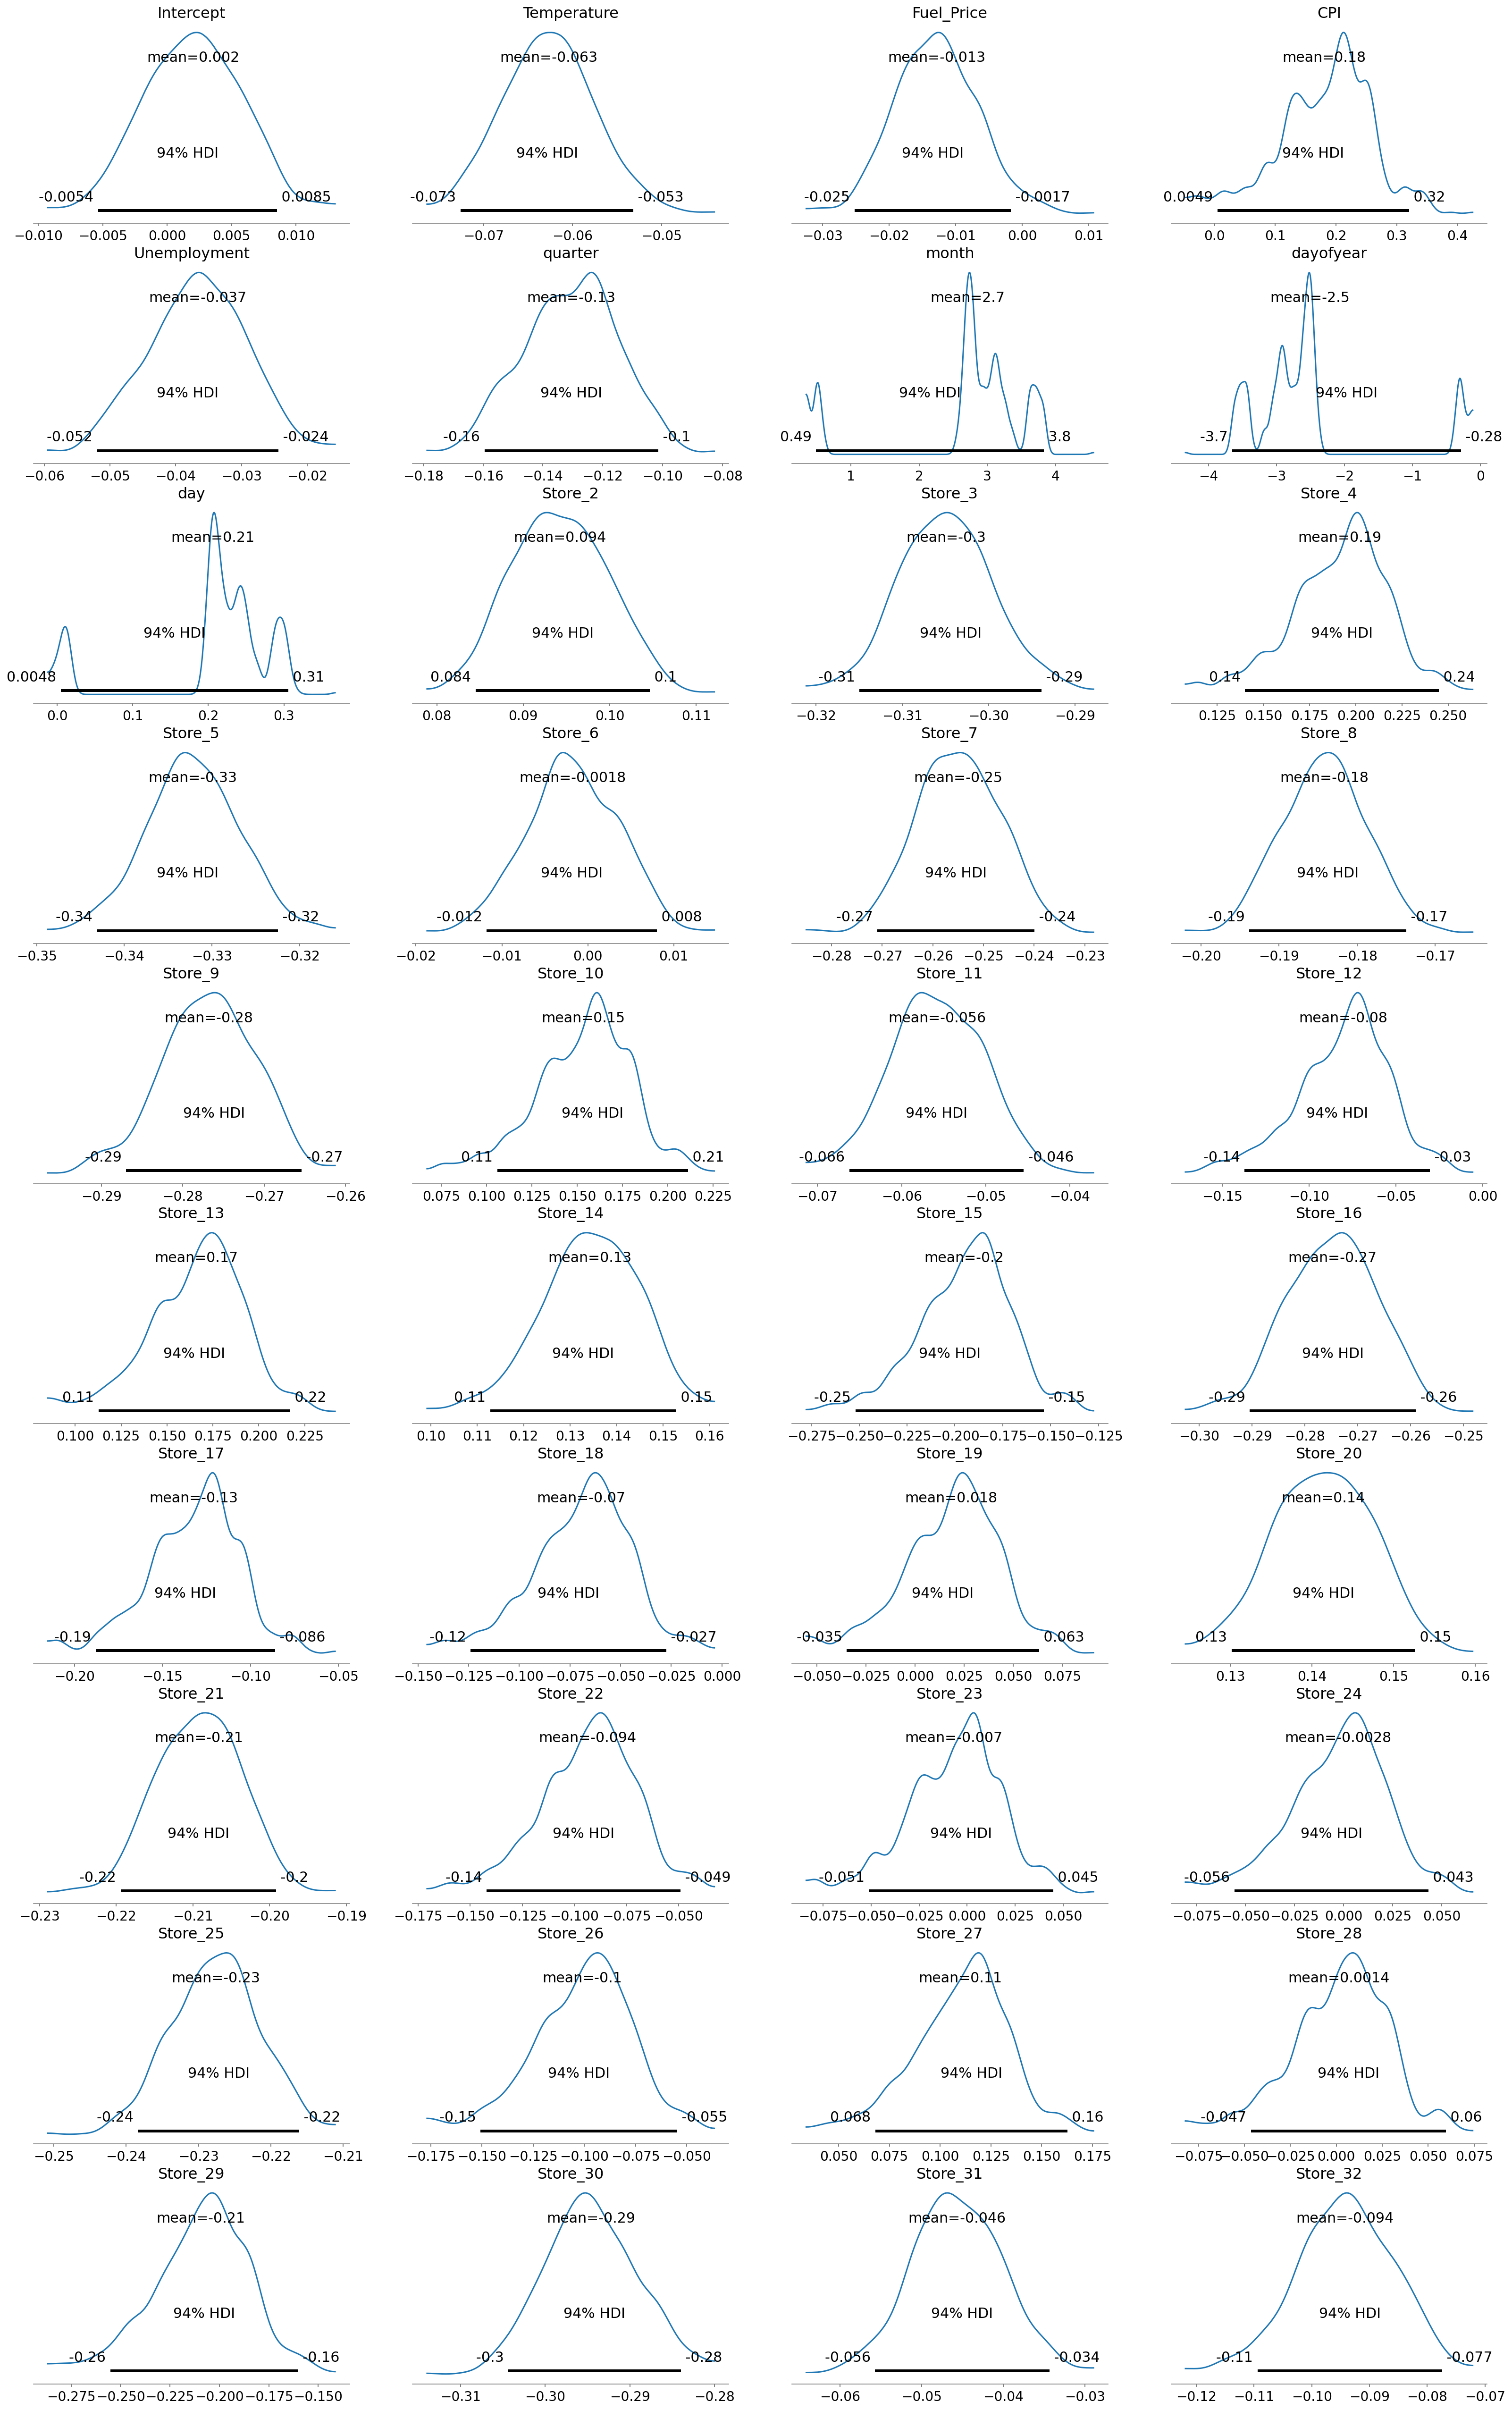

In [ ]:
pm.plot_posterior(trace_log)

In [ ]:
pm.summary(trace_log)


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

  warnings.warn(

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.004,0.014,-0.032,0.022,0.000,0.000,1189.0,592.0,NaN
Temperature,-0.062,0.016,-0.091,-0.035,0.001,0.000,888.0,767.0,NaN
Fuel_Price,-0.006,0.015,-0.038,0.019,0.001,0.001,884.0,700.0,NaN
CPI,-0.083,0.015,-0.110,-0.055,0.001,0.000,868.0,679.0,NaN
Unemployment,-0.099,0.014,-0.129,-0.075,0.000,0.000,1309.0,820.0,NaN
quarter,-0.180,0.054,-0.275,-0.073,0.003,0.002,292.0,294.0,NaN
month,1.972,1.650,-0.554,6.085,0.173,0.136,90.0,115.0,NaN
dayofyear,-1.715,1.658,-4.864,1.795,0.174,0.139,91.0,115.0,NaN
day,0.132,0.147,-0.115,0.478,0.015,0.013,91.0,122.0,NaN
sd,0.986,0.009,0.969,1.002,0.000,0.000,1528.0,480.0,NaN


<ipython-input-141-2042e0927c2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.

  pm.traceplot(trace_log)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

  warnings.warn(

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (55), generating only 20 plots

  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3d253280>,
      dtype=object)

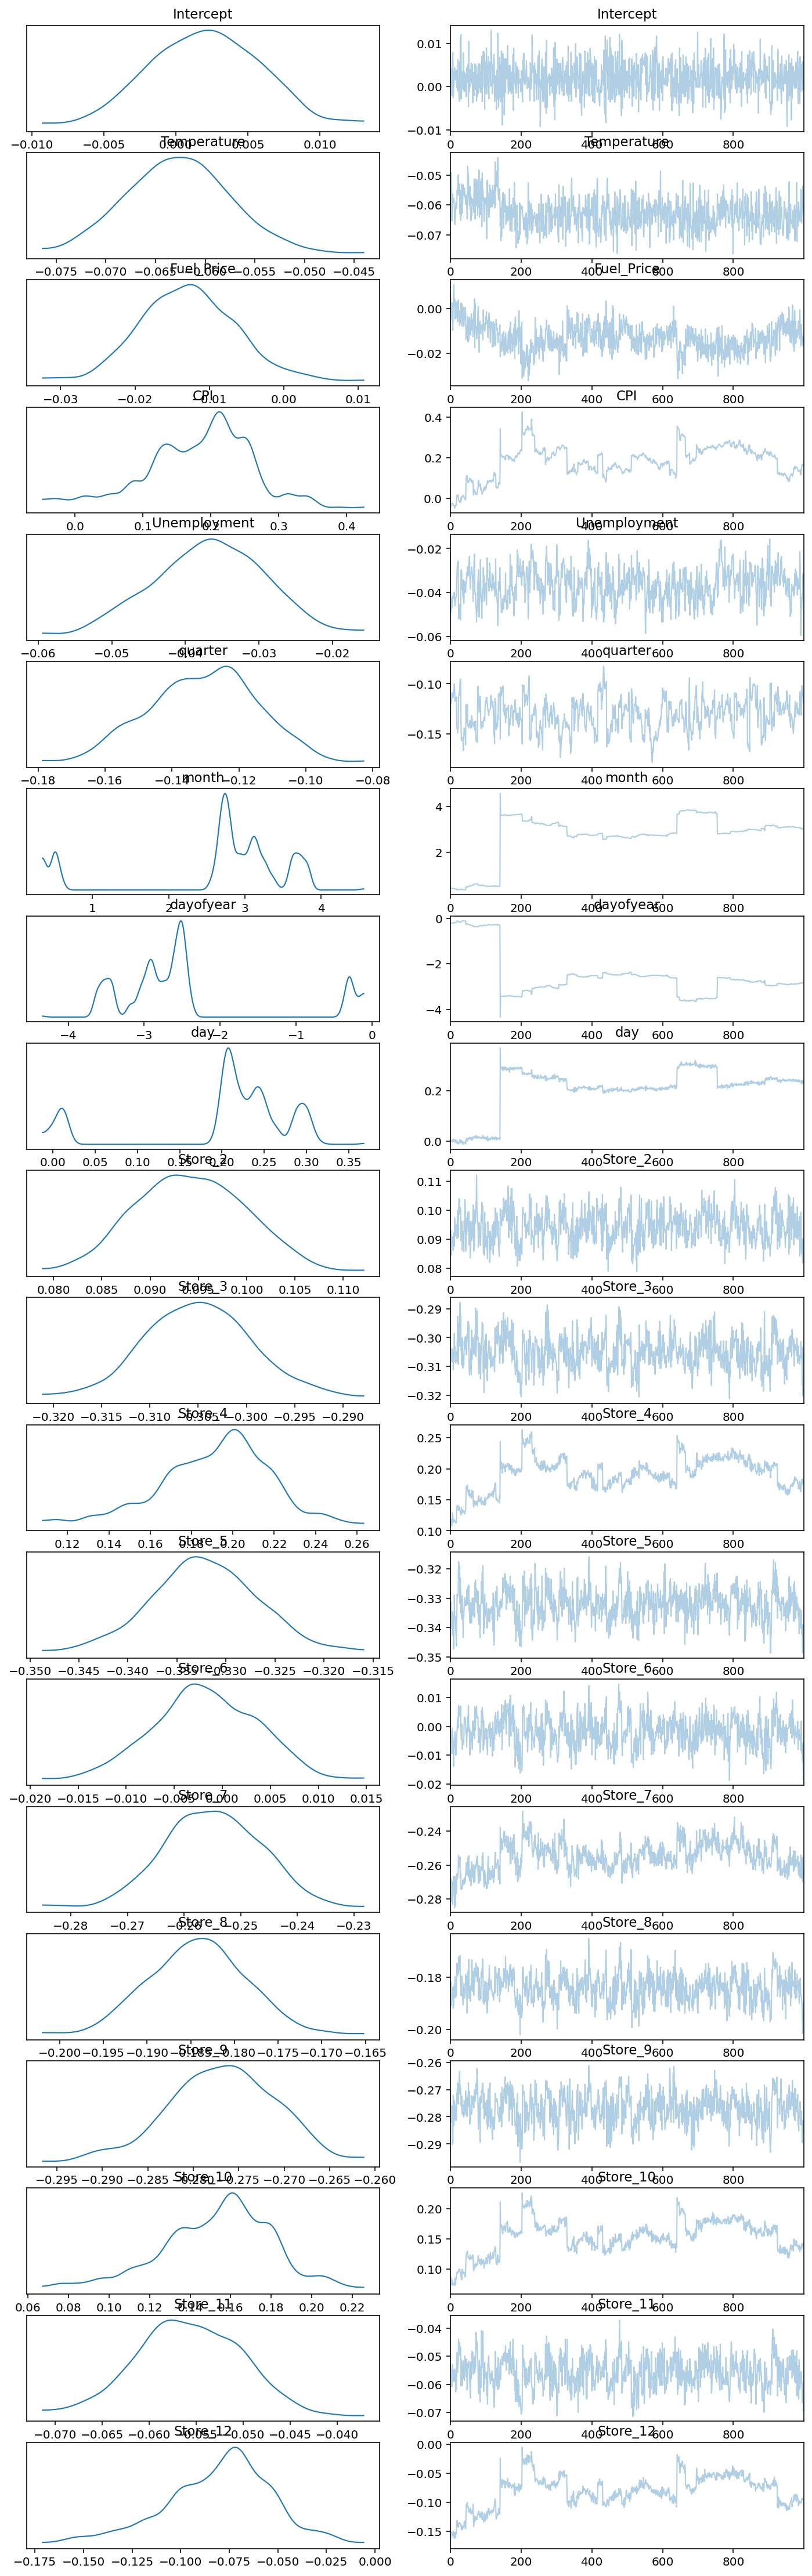

In [ ]:
pm.traceplot(trace_log)

<ipython-input-142-1783ad39caff>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.

  pm.forestplot(trace_log)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3e0f6ca0>],
      dtype=object)

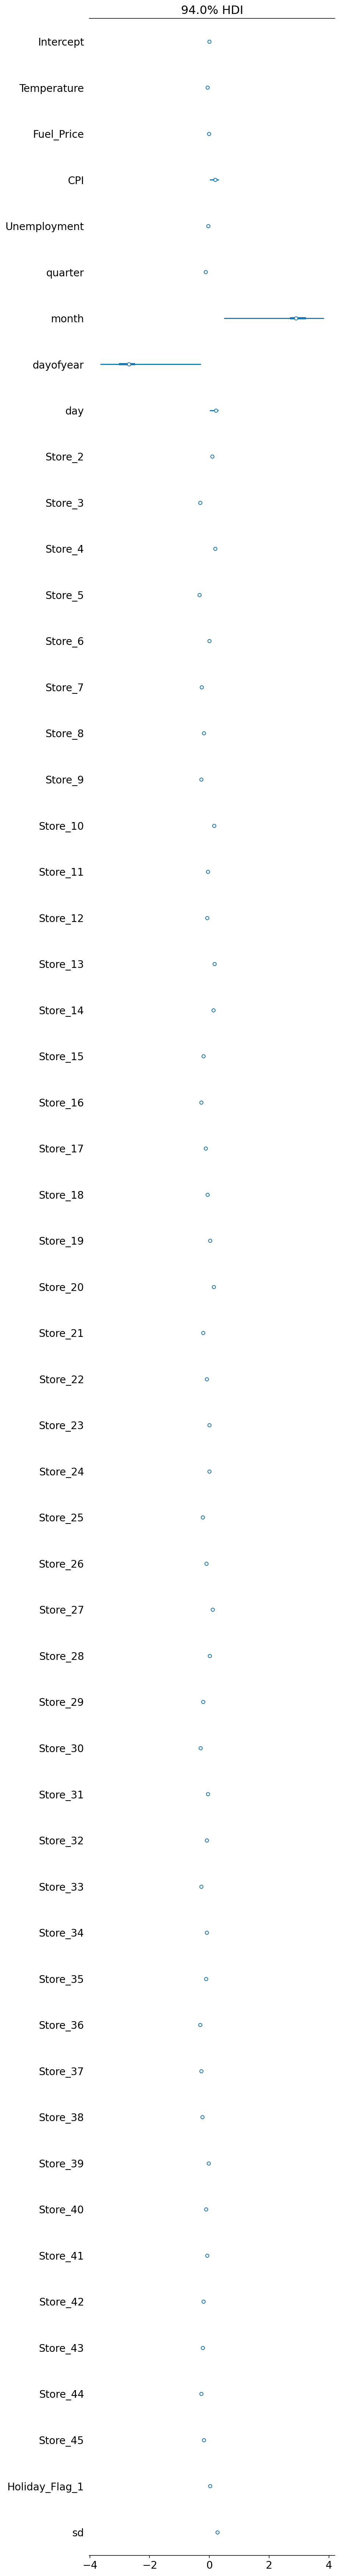

In [ ]:
pm.forestplot(trace_log)

<ipython-input-143-1f772dcd400a>:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.

  pm.autocorrplot(trace_log)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

  warnings.warn(

/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_autocorr, generating only 40 plots

  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3d3f95b0>,
      dtype=object)

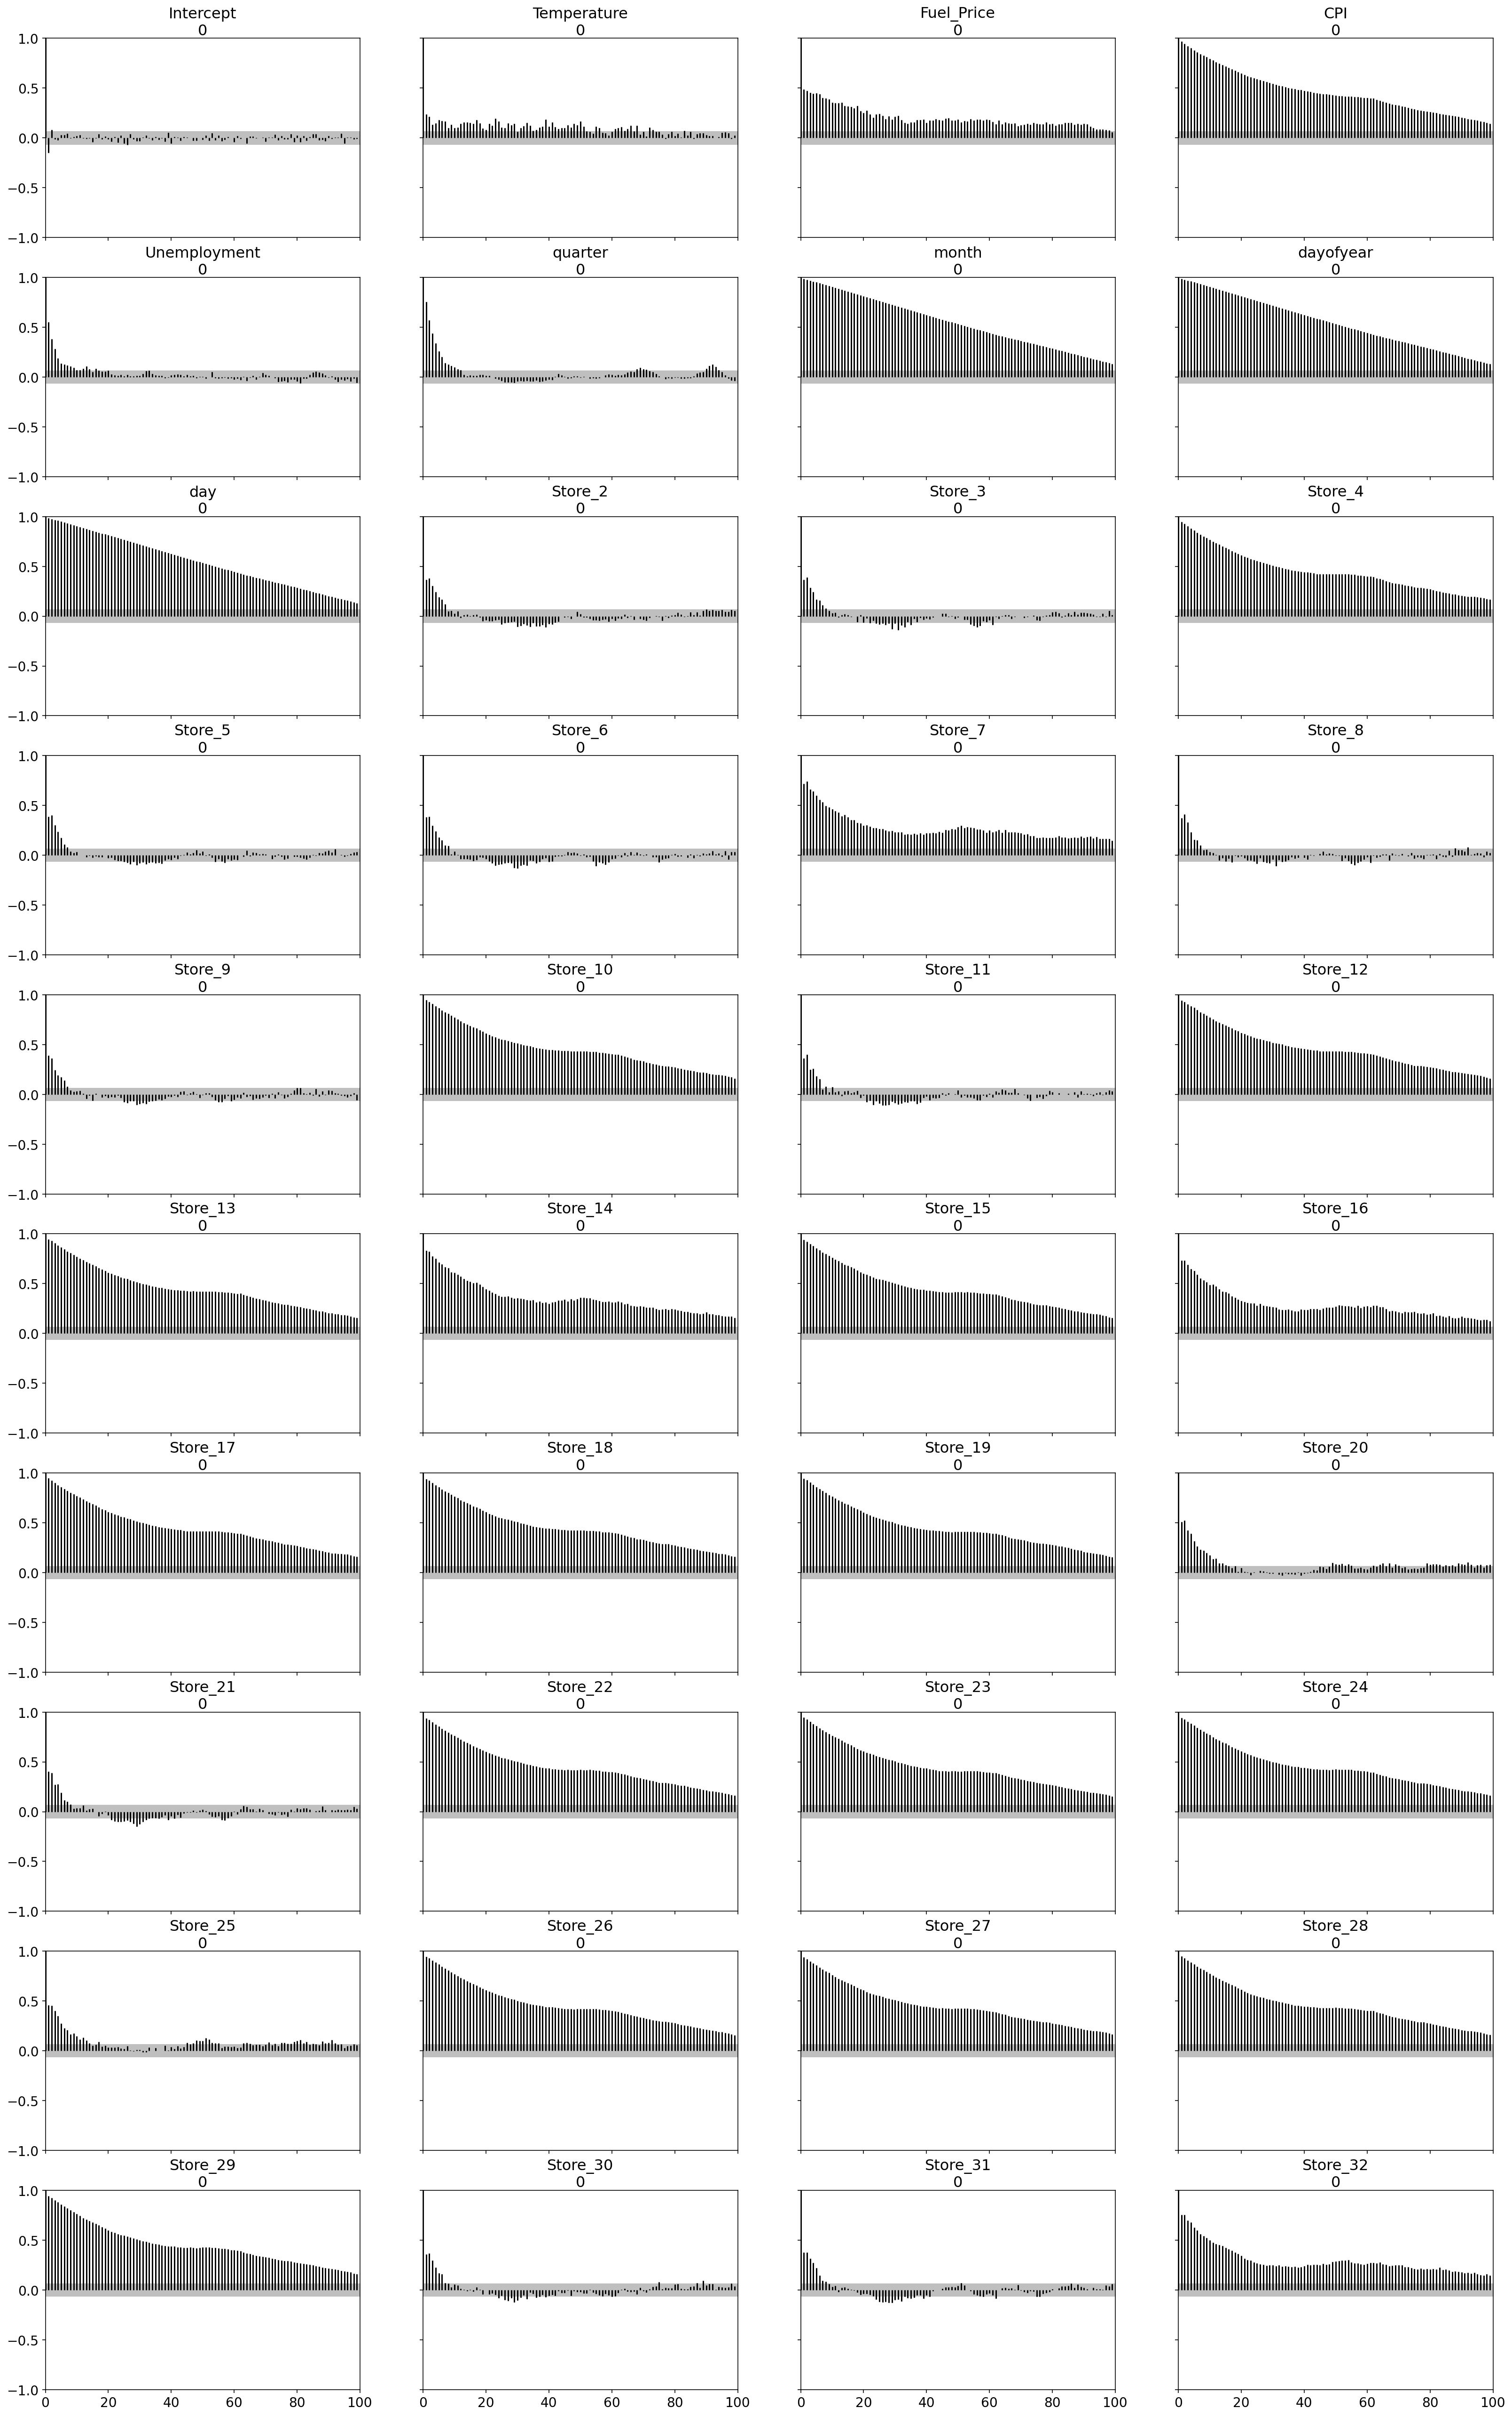

In [ ]:
pm.autocorrplot(trace_log)